## Project Code

**Preparation:**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

pd.set_option('precision', 2)                    # Setting prices to exclude decimal points

pd.set_option('display.max_columns', 500)        # Setting DataFrame columns to show all of them

pd.options.mode.chained_assignment = None        # default='warning signs', when adding new columns to data frames

from sklearn.model_selection import train_test_split     # split data into random train and test subsets

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import  mean_squared_error

**Open files to dataframes:**

In [2]:
# Open housing data into a dataframe
dtitles = pd.DataFrame.from_csv('Housing_data/test.csv', index_col=None)

# Open housing price data into a dataframe
dprices = pd.DataFrame.from_csv('Housing_data/sample_submission.csv', index_col=None)

# open weather data file
weather_d = pd.DataFrame.from_csv('Weather_data/weather.csv', index_col=None)           

C:\Users\Alfredo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
C:\Users\Alfredo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """
C:\Users\Alfredo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


**Outliers and bad data:**

[Exploratory Data Analysis](https://github.com/AlfredMtz/Springboard/blob/master/Ames_project/EDA_for_bad_data.ipynb)

**Wrangle housing data:**

In [3]:
# Merge/combine the properties' descriptions and its sales prices into a new dataframe.
h_data = pd.merge(dtitles, dprices, on='Id')

# Filtering from 2006-2009!
hs_data = h_data[(h_data.YrSold >= 2006) & (h_data.YrSold <= 2009)] 

# Remove columns/features with more than 1000 NaN values
hs_data = hs_data.dropna(axis=1, thresh=1000)

# Rename columns
hs_data = hs_data.rename(columns={"MoSold":"month", "YrSold":"year"})          

# Building dataframe to a series datetime index                                                                          
hs_data.loc[:, 'day'] = 1                                                       

# adding column as one datetime.
date = pd.to_datetime(hs_data[['year', 'month', 'day']])                        
hs_data.loc[:, 'Date'] = date
hs_data.loc[:, 'Date'] = hs_data.Date.dt.to_period('M')
                                                                                   
# Seting, sorting and renaming index
hs_data = hs_data.set_index('Date').sort_index()                               
hs_data.drop(['day'], axis=1, inplace=True)

# changing/rename index to string object for later joining
hs_data.index = hs_data.index.map(str).rename('Year_Month')

**Cleaning weather data and join dataframes:**

In [4]:
# Sorting to data needed
weather_d1 = weather_d[weather_d.STATION_NAME == 'AMES 8 WSW IA US']                   
weather_d2 = weather_d1[(weather_d1.DATE >= 20060101) & (weather_d1.DATE <= 20091231)]
weather_d3 = weather_d2[['DATE', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]

 # Getting date to datetime, setting and sortinging index to ('Date')
weather_d3.loc[:, 'Date'] = pd.to_datetime(weather_d3.DATE, format='%Y%m%d')           
weather_d4 = weather_d3[['Date', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]                      

# Building and setting index to year, and month.
weather_d4['Date'] =weather_d4.Date.dt.to_period('M')                                   
weather_data = weather_d4.set_index('Date').sort_index()                                 

# Changed corrupted values to Not a Number(NaN)
weather_data[weather_data == -9999] = np.nan                                   

# Changed names for columns
col = ['Avg_Prcp', 'Avg_Snow', 'Avg_Tmax', 'Avg_Tmin']                          
weather_data.columns = col

# Getting weather averages
wth_data_avg = weather_data.groupby(weather_data.index).mean()                 

# Change index type to string object for later merging of dataframes
wth_data_avg.index = wth_data_avg.index.map(str).rename('Year_Month') 

# join new housing and weather dataframes
hs_wth_data = hs_data.join(wth_data_avg)

# changing index to dates
hs_wth_df = hs_wth_data.reset_index(level=['Year_Month'])

# Drop 'Id' column, not needed
data = hs_wth_df.drop('Id', 1)

**Data Split:**

In [5]:
# Value drop
X, y = data.drop(['Year_Month', 'SalePrice'], axis=1), data.SalePrice

# Data split
X_trainp, X_testp, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 5)

print(X_trainp.shape)
print(X_testp.shape)
print(y_train.shape)
print(y_test.shape)

(906, 78)
(389, 78)
(906,)
(389,)


**Fill not a number(NaN) with values for X_train:**

In [6]:
# Fix values for X_train

# Fill float(numerical) columns' NaN values with means
X_trainp[['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']] = X_trainp[
    ['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']].fillna(
    X_trainp[['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']].mean())

# Fill int(numerical) columns' NaN values with mode, most frequent
X_trainp[['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']] = X_trainp[
    ['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']].fillna(
    X_trainp[['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']].mode().iloc[0])

# find categorical features
#categorical_features = attach_all_data.select_dtypes(include=['object'])

# Fill categorical columns' NaN values with mode, most frequent
X_trainp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig','LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']] = X_trainp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig'
            ,'LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']].fillna(X_trainp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig'
            ,'LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']].mode().iloc[0])

X_train_dummies = pd.get_dummies(X_trainp)
X_train = X_train_dummies
X_train.shape

(906, 255)

**Fill not a number(NaN) with values for X_test:**

In [7]:
# Fix values for X_test 

# Fill float columns' NaN values with means
X_testp[['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']] = X_testp[
    ['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']].fillna(
    X_trainp[['LotFrontage', 'MasVnrArea','GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']].mean())

# Fill int columns' NaN values with mode, most frequent
X_testp[['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']] = X_testp[
    ['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']].fillna(
    X_trainp[['GarageYrBlt','BsmtFullBath','BsmtHalfBath', 'GarageCars']].mode().iloc[0])

# Fill categorical columns' NaN values with mode, most frequent
X_testp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig'
            ,'LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']] = X_testp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig'
            ,'LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']].fillna(X_trainp[['MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig'
            ,'LandSlope', 'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl'
            ,'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'
            ,'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual'
            ,'Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType'
            ,'SaleCondition']].mode().iloc[0])

X_test_dummies = pd.get_dummies(X_testp)
X_test = X_test_dummies.reindex(columns = X_train_dummies.columns).fillna(0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(906, 255)
(389, 255)
(906,)
(389,)


**Model:**

In [8]:
# It averages to one overall mean, from the mean prediction of each individual tree
# to improve the predictive accuracy and controls overfitting from single decision trees
rfr = RandomForestRegressor()

# Range of different parameters, try to find the bests between these.
param_grid = {'n_estimators': [100, 250, 300],
             'max_features' : ["auto", "sqrt", "log2"],
             'max_depth'    : [2,4,8],
             "bootstrap"    : [True, False]}

# Search for previous specify parameters, within the given estimator RandomForestRegressor()
rfr_grid = GridSearchCV(rfr, param_grid)

# Build a forest of trees from the training set (X_train, y_train)
rfr_grid.fit(X_train, y_train)

# regr_grid.best_params_ --> Function to see best parameters
# Take best found parameters and predict values
y_predict = rfr_grid.best_estimator_.predict(X_test)

In [9]:
rfr_grid.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 100}

**Performance:**

In [10]:
# Mean Square Error
MSE = mean_squared_error(y_test, y_predict)

# Root Mean Square Error
RMSE = sqrt(MSE)
print("RMSE:", RMSE)

RMSE: 4202.622129238704


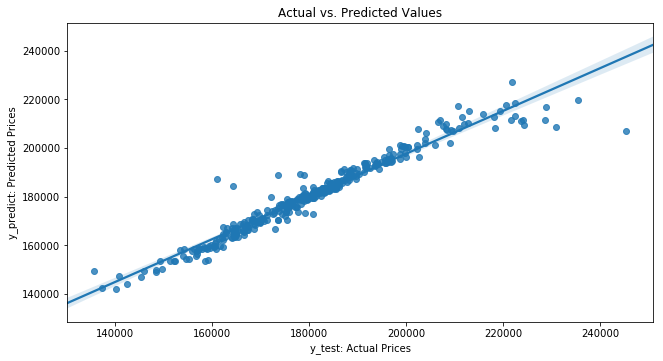

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
ax = sns.regplot(y_test, y_predict)
ax.set_title('Actual vs. Predicted Values')
ax.set_xlabel('y_test: Actual Prices')
ax.set_ylabel('y_predict: Predicted Prices')
plt.show()

In [12]:
rfr_bp = rfr_grid.best_estimator_.fit(X_train, y_train)
result = pd.DataFrame(list(zip(X_train.columns,  rfr_bp.feature_importances_)), columns=['Features', 'Importance'])
results = result.sort_values('Importance', ascending=False)
results.head(10)

,Features,Importance
20,BedroomAbvGr,5.66e-01
2,LotArea,3.82e-01
34,month,1.72e-02
28,OpenPorchSF,2.33e-03
38,Avg_Tmax,2.17e-03
15,GrLivArea,2.15e-03
39,Avg_Tmin,1.95e-03
10,BsmtUnfSF,1.71e-03
215,Functional_Min1,1.36e-03
1,LotFrontage,1.12e-03


C:\Users\Alfredo\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


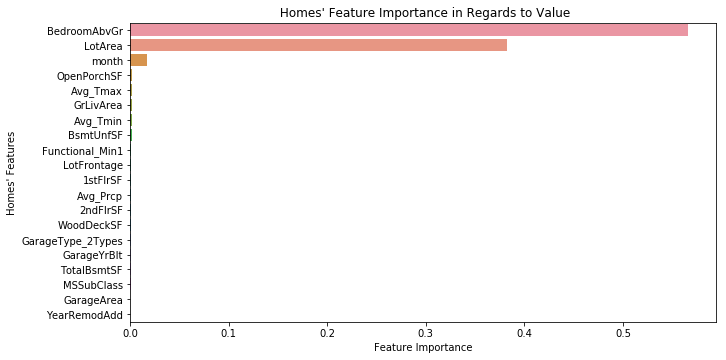

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)
sns.barplot(results['Importance'][:20], results['Features'][:20])
ax.set_title(" Homes' Feature Importance in Regards to Value")
ax.set_xlabel('Feature Importance')
ax.set_ylabel("Homes' Features")
plt.show()